<a href="https://colab.research.google.com/github/popkdodge/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# TODO - your code!

In [0]:
'''

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-05-12 19:29:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-05-12 19:29:42 (286 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [0]:
column_headers = ['party','handicapped-infants','water-project',
                  'budget','physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups','anti-satellite-ban',
                  'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime','duty-free',
                  'south-africa']

df = pd.read_csv('house-votes-84.data', names=column_headers)
df = df.replace({"y": 1, "n": 0, "?": np.NaN})
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
sample = df.sample(50)

In [0]:
def under_confient_interval (sample, confidence=0.95):
  #drop NaN values
  no_nan = sample.dropna()
  #finding samplie x_bar values
  x_bar = np.mean(no_nan)
  #finding std of sample
  std = np.std(no_nan, ddof=1)
  #finding the sample amounts
  sample_ammount = len(no_nan)
  #calculate t
  t_score = stats.t.ppf((1 + confidence) / 2.0, sample_ammount - 1)
  #finding std error
  std_err = std / np.sqrt(sample_ammount)
  #finding margin of error
  margin_of_error = t_score*std_err
  #Identifying upper and lower bound
  lower_bound = x_bar - margin_of_error
  upper_bound = x_bar + margin_of_error

  return (lower_bound, x_bar, upper_bound)


In [0]:
test_data_conf_int = under_confient_interval(sample['water-project'])
test_data_conf_int

(0.34987759726001133, 0.5, 0.6501224027399887)

In [0]:
lower, mean, upper = test_data_conf_int
moe = upper - mean
print(moe)

0.15012240273998867


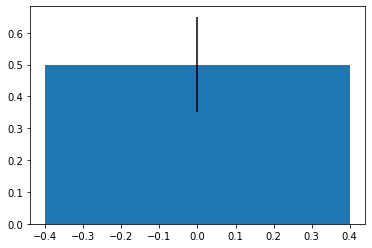

In [0]:
plt.bar(0, mean, yerr=moe)
plt.show()

In [0]:
#the confidence interval is showing the sample mean of members of congress that voted for the water project is 0.5%
# there is a margin of error of 15.0% that mean there is a 95% chance that the actual votes can be in the ranges of 34.9% to 65.0% in aggreement with the water project.

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data

--2020-05-12 20:19:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51867 (51K) [application/x-httpd-php]
Saving to: ‘car.data’

car.data            100%[===================>]  50.65K  --.-KB/s    in 0.1s    

2020-05-12 20:19:50 (390 KB/s) - ‘car.data’ saved [51867/51867]



In [0]:
car_column_header = ["Cost", "MaintanceCost", "Doors", "Person", "Lug_boot_size", "Safety", "Acceptability"]

In [0]:
car = pd.read_csv('car.data', names=car_column_header)

In [0]:
car

,Cost,MaintanceCost,Doors,Person,Lug_boot_size,Safety,Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [0]:
observed_margins = pd.crosstab(car['Cost'], car['Acceptability'], margins=True)
observed = pd.crosstab(car['Cost'], car['Acceptability'])
observed_margins

Acceptability,acc,good,unacc,vgood,All
Cost,,,,,
high,108,0,324,0,432
low,89,46,258,39,432
med,115,23,268,26,432
vhigh,72,0,360,0,432
All,384,69,1210,65,1728


In [0]:
row_sums = observed_margins.iloc[0:4, 4:].values
row_sums = row_sums.T[0]

row_sums

array([432, 432, 432, 432])

In [0]:
col_sums = observed_margins.iloc[4:, :4].values
col_sums = col_sums[0]

col_sums

array([ 384,   69, 1210,   65])

In [0]:
total_total = df.shape[0]

total_total

435

In [0]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total_total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)  
print(expected)

(5, 5)
[[ 381.35172414   68.52413793 1201.65517241   64.55172414 1716.08275862]
 [ 381.35172414   68.52413793 1201.65517241   64.55172414 1716.08275862]
 [ 381.35172414   68.52413793 1201.65517241   64.55172414 1716.08275862]
 [ 381.35172414   68.52413793 1201.65517241   64.55172414 1716.08275862]
 [1525.40689655  274.09655172 4806.62068966  258.20689655 6864.33103448]]


In [0]:
chi2 = ((observed - expected)**2 / expected).sum().sum()

chi2

189.24300964187327

In [0]:
#(number of rows of contingency -1)*(number of columns of contingency-1) = degrees of freedom
#dof = 3*3 = 9 

<img src="https://i.gyazo.com/c97d76019aa76ef105a2e4631a5cdf21.png" width=400>


In [0]:
from scipy import stats

# pass in our observed value table (contingency table)
chi2, p_value, dof, expected = stats.chi2_contingency(observed)

print(" chi2 statistic", chi2)
print("\n p-value", p_value)
print("\n degrees of freedom",dof)
print("\n expected frequencies table: \n", expected)

 chi2 statistic 189.24300964187327

 p-value 5.9280625992133936e-36

 degrees of freedom 9

 expected frequencies table: 
 [[ 96.    17.25 302.5   16.25]
 [ 96.    17.25 302.5   16.25]
 [ 96.    17.25 302.5   16.25]
 [ 96.    17.25 302.5   16.25]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

1) Null Hypothesis:

Congress as a whole are split in the middle with the decision to pass the "water-project" bill.

2) Alternative Hypothesis

Congress as a whole are indecisive about their decision are partisan in their decisian to pass "water-project' bill.

There is a relationship

3) Confidence Level: 95%

4) Conclusions:

Congress a whole is moderately split in the middle because the mean is around 50% and give or take 15% is the chance of the bill passing. I fail to reject the theory that congress are split in the middle with the decision to pass the "water-project' bill.


In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
train, test = train_test_split(sns.load_dataset('titanic').drop(columns=['alive']), random_state=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
observed_margins = pd.crosstab(car['Cost'], car['Acceptability'], margins=True)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
105,0,3,male,28.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,True
68,1,3,female,17.0,4,2,7.9250,S,Third,woman,False,NaN,Southampton,False
253,0,3,male,30.0,1,0,16.1000,S,Third,man,True,NaN,Southampton,False
320,0,3,male,22.0,0,0,7.2500,S,Third,man,True,NaN,Southampton,True
706,1,2,female,45.0,0,0,13.5000,S,Second,woman,False,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,1,1,female,39.0,1,1,83.1583,C,First,woman,False,E,Cherbourg,False
192,1,3,female,19.0,1,0,7.8542,S,Third,woman,False,NaN,Southampton,False
629,0,3,male,NaN,0,0,7.7333,Q,Third,man,True,NaN,Queenstown,True
559,1,3,female,36.0,1,0,17.4000,S,Third,woman,False,NaN,Southampton,False


In [6]:
observed_margins_st = pd.crosstab(train['sex'], train['survived'])
observed_margins_st

survived,0,1
sex,,
female,57,174
male,353,84


In [7]:
from scipy import stats

# pass in our observed value table (contingency table)
chi2, p_value, dof, expected = stats.chi2_contingency(observed_margins_st)

print(" chi2 statistic", chi2)
print("\n p-value", p_value)
print("\n degrees of freedom",dof)
print("\n expected frequencies table: \n", expected)

 chi2 statistic 198.28792707609887

 p-value 4.936877781936846e-45

 degrees of freedom 1

 expected frequencies table: 
 [[141.78143713  89.21856287]
 [268.21856287 168.78143713]]


1) Null Hypothesis:

Sex have and survival chances are independenly related.

2) Alternative Hypothesis

Sex and survival chances are dependly related.

There is a relationship

3) Confidence Level: 95%

4) Conclusion: Due to a chi2 value of 198.287, and a p-value of 0. We reject the null hypothesis that sex survival chance are independent, and suggest the alternative, that they are strongly associated.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)